## Задание 1

In [7]:
import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML 
import pymorphy2
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

%matplotlib inline

In [13]:
wiki = open('wiki_data.txt', encoding = 'utf-8').read().split('\n')

def return_lemma(token):
    return morph.parse(token)[0].normal_form

In [14]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [return_lemma(token) for token in tokens]
    return tokens

In [17]:
vocab = Counter()

for text in wiki:
    vocab.update(preprocess(text))
    
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)
        
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}
sentences = []

for text in wiki:
    tokens = preprocess(text)
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

In [22]:
vocab_size = len(id2word)

total_words = 0
for w in list(vocab.keys()):
    if w in filtered_vocab:
        total_words += vocab[w]
probas = [vocab[w]/total_words for w in filtered_vocab ]

In [23]:
def gen_batches_sg(sentences, window = 6, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    X_target.append(word)
                    X_context.append(word2id[np.random.choice(list(filtered_vocab), p=probas)])
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [50]:
def gen_batches_cbow(sentences, window, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window//2):i] + sent[i+1:i+window//2]

                X_target.append(word)
                X_context.append(context)
                y.append(1)
                
                X_target.append(word2id[np.random.choice(list(filtered_vocab), p=probas)])
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window*2)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

### skip-gram

In [25]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

sg_model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
sg_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [26]:
sg_model.fit(gen_batches_sg(sentences[:19000], window=12),
          validation_data=gen_batches_sg(sentences[19000:],  window=12),
          batch_size=1000,
          steps_per_epoch=3000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
3000/3000 [==============================] - 8714s 3s/step - loss: 0.6810 - accuracy: 0.5494 - val_loss: 0.6886 - val_accuracy: 0.5329
Epoch 2/2
3000/3000 [==============================] - 9756s 3s/step - loss: 0.6667 - accuracy: 0.5755 - val_loss: 0.6659 - val_accuracy: 0.5883


In [27]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in 
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [28]:
sg_embeddings = sg_model.layers[2].get_weights()[0]

In [29]:
most_similar('судьба', sg_embeddings)

['судьба',
 'оказываться',
 'проявлять',
 'наслать',
 'неудачный',
 'ради',
 'ад',
 'верить',
 'сюжет',
 'всегда']

In [30]:
most_similar('библия', sg_embeddings)

['библия',
 'далёкий',
 'равный',
 'идентичный',
 'прежде',
 'внешне',
 'обеспечивать',
 'необходимый',
 'влияние',
 'выяснить']

### cbow

In [46]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

cbow_model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
cbow_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [51]:
cbow_model.fit(gen_batches_cbow(sentences[:10000], window=6),
          validation_data=gen_batches_cbow(sentences[10000:], window=6),
          batch_size=1000,
          steps_per_epoch=1000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
1000/1000 [==============================] - 6750s 7s/step - loss: 0.6500 - accuracy: 0.6025 - val_loss: 0.6113 - val_accuracy: 0.6566
Epoch 2/2
1000/1000 [==============================] - 3019s 3s/step - loss: 0.5978 - accuracy: 0.6727 - val_loss: 0.5853 - val_accuracy: 0.6827


In [57]:
cbow_embeddings = cbow_model.layers[2].get_weights()[0]

In [58]:
most_similar('судьба', cbow_embeddings)

['судьба',
 'убеждение',
 'узнать',
 'возможность',
 'ставить',
 'существо',
 'понимание',
 'хотеть',
 'внутри',
 'из-за']

In [59]:
most_similar('библия', cbow_embeddings)

['библия',
 'перевод',
 'заголовок',
 'высокочастотный',
 'мультсериал',
 'грузинский',
 'брод',
 'армянский',
 'уродить',
 'пустынный']

## Задание 2

In [60]:
import gensim

In [64]:
wiki = open('wiki_data.txt', encoding = 'utf-8').read().split('\n')
texts = [preprocess(text) for text in wiki]

In [65]:
w2v = gensim.models.Word2Vec(texts)

In [66]:
%%time
w2v = gensim.models.Word2Vec(texts, 
                             vector_size = 100, 
                             min_count = 20, 
                             max_vocab_size = 12000,
                             window = 6,
                             epochs = 10,
                             sg = 0,
                             negative = 10)

Wall time: 44.4 s


In [67]:
w2v.wv.similar_by_word('судьба')

[('рассказывать', 0.6021789312362671),
 ('рассказать', 0.5571690797805786),
 ('узнать', 0.5498092174530029),
 ('любовь', 0.5396974682807922),
 ('узнавать', 0.5395961403846741),
 ('перси', 0.5262677669525146),
 ('ничего', 0.5252251029014587),
 ('убивать', 0.5202212929725647),
 ('гибель', 0.5154215097427368),
 ('просить', 0.5040279626846313)]

In [72]:
%%time
ft = gensim.models.FastText(texts, min_n=7, max_n=13)

Wall time: 2min 53s


In [73]:
ft.wv.most_similar('судьба')

[('«судьба', 0.8315027952194214),
 ('заботиться', 0.7801317572593689),
 ('правда', 0.7736448645591736),
 ('мысль', 0.7621597647666931),
 ('мечта', 0.7558774948120117),
 ('позаботиться', 0.7523524761199951),
 ('рассказывать', 0.7465763688087463),
 ('узнать', 0.743129551410675),
 ('заговорить', 0.7386758923530579),
 ('рассказать', 0.7382193803787231)]

In [74]:
ft.wv.most_similar('библия')

[('«библия', 0.8701739311218262),
 ('хроника', 0.8610767126083374),
 ('генеалогия', 0.8248050808906555),
 ('грамматик', 0.8202798962593079),
 ('грамматика', 0.8110436201095581),
 ('рукопись', 0.8056421875953674),
 ('«истории»', 0.8051820993423462),
 ('хроник', 0.800186276435852),
 ('жизнеописание', 0.7992774844169617),
 ('трактат', 0.7978590726852417)]

## Задание 3

In [76]:
data = pd.read_csv('labeled.csv')
data['norm_text'] = data.comment.apply(preprocess)

In [88]:
vocab = Counter()

for text in data['norm_text']:
    vocab2.update(text)
    
filtered_vocab2 = set()

for word in vocab2:
    if vocab2[word] > 5:
        filtered_vocab2.add(word)

len(filtered_vocab2)

word2id2 = { 'PAD':0}

for word in filtered_vocab2:
    word2id2[word] = len(word2id2)
id2word2 = {i:word for word, i in word2id2.items()}

X = []

for tokens in data['norm_text']:
    ids = [word2id2[token] for token in tokens if token in word2id2]
    X.append(ids)
    
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = data.toxic.values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

## sg

In [130]:
sg_weights = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    if word == 'PAD':
        continue
    try:
        sg_weights[i] = sg_embeddings[word2id[word]]
    except KeyError:
        continue
        sg_weights[i] = sg_embeddings[word2id['опрагпллирао']]

In [105]:
inputs = tf.keras.layers.Input(shape = (100,))

embeddings = tf.keras.layers.Embedding(input_dim = len(word2id), output_dim = 100, 
                                       trainable = False,
                                       weights = [sg_weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis = 1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(mean)

sg_model = tf.keras.Model(inputs = inputs, outputs = outputs)
optimizer = tf.keras.optimizers.Adam()
sg_model.compile(optimizer = optimizer,
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [108]:
sg_model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

Epoch 1/30
428/428 [==============================] - 2s 5ms/step - loss: 0.6083 - accuracy: 0.6673 - val_loss: 0.6382 - val_accuracy: 0.6297
Epoch 2/30
428/428 [==============================] - 2s 6ms/step - loss: 0.6074 - accuracy: 0.6673 - val_loss: 0.6374 - val_accuracy: 0.6297
Epoch 3/30
428/428 [==============================] - 2s 6ms/step - loss: 0.6066 - accuracy: 0.6676 - val_loss: 0.6371 - val_accuracy: 0.6297
Epoch 4/30
428/428 [==============================] - 3s 6ms/step - loss: 0.6058 - accuracy: 0.6674 - val_loss: 0.6367 - val_accuracy: 0.6311
Epoch 5/30
428/428 [==============================] - 3s 6ms/step - loss: 0.6050 - accuracy: 0.6685 - val_loss: 0.6366 - val_accuracy: 0.6297
Epoch 6/30
428/428 [==============================] - 3s 6ms/step - loss: 0.6044 - accuracy: 0.6692 - val_loss: 0.6356 - val_accuracy: 0.6297
Epoch 7/30
428/428 [==============================] - 3s 6ms/step - loss: 0.6037 - accuracy: 0.6696 - val_loss: 0.6353 - val_accuracy: 0.6297
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


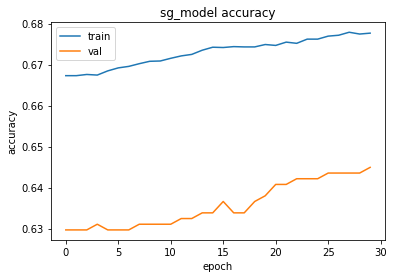

In [109]:
print(sg_model.history.history.keys())
plt.plot(sg_model.history.history['accuracy'])
plt.plot(sg_model.history.history['val_accuracy'])
plt.title('sg_model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## cbow

In [131]:
cbow_weights = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    if word == 'PAD':
        continue
    try:
        cbow_weights[i] = cbow_embeddings[word2id[word]]
    except KeyError:
        continue
        cbow_weights[i] = cbow_embeddings[word2id['опрагпллирао']]

In [126]:
inputs = tf.keras.layers.Input(shape = (100,))

embeddings = tf.keras.layers.Embedding(input_dim = len(word2id), output_dim = 100, 
                                       trainable = False,
                                       weights = [cbow_weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis = 1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(mean)

model = tf.keras.Model(inputs = inputs, outputs = outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer = optimizer,
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [132]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

Epoch 1/30
428/428 [==============================] - 3s 6ms/step - loss: 0.6122 - accuracy: 0.6671 - val_loss: 0.6421 - val_accuracy: 0.6283
Epoch 2/30
428/428 [==============================] - 2s 6ms/step - loss: 0.6119 - accuracy: 0.6670 - val_loss: 0.6418 - val_accuracy: 0.6283
Epoch 3/30
428/428 [==============================] - 2s 6ms/step - loss: 0.6116 - accuracy: 0.6670 - val_loss: 0.6413 - val_accuracy: 0.6283
Epoch 4/30
428/428 [==============================] - 3s 6ms/step - loss: 0.6113 - accuracy: 0.6670 - val_loss: 0.6407 - val_accuracy: 0.6283
Epoch 5/30
428/428 [==============================] - 3s 6ms/step - loss: 0.6110 - accuracy: 0.6670 - val_loss: 0.6405 - val_accuracy: 0.6283
Epoch 6/30
428/428 [==============================] - 3s 6ms/step - loss: 0.6107 - accuracy: 0.6671 - val_loss: 0.6402 - val_accuracy: 0.6283
Epoch 7/30
428/428 [==============================] - 2s 6ms/step - loss: 0.6105 - accuracy: 0.6671 - val_loss: 0.6399 - val_accuracy: 0.6283
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


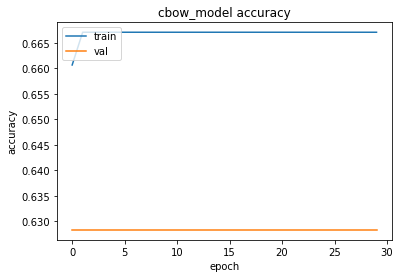

In [128]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('cbow_model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## ft

In [121]:
%%time
ft = gensim.models.FastText(texts + data['norm_text'].values.tolist(), window=10, epochs=10)

Wall time: 16min 53s


In [122]:
ft_weights = np.zeros((len(word2id2), 100))

for word, i in word2id2.items():

    if word == 'PAD':
        continue

    try:
        ft_weights[i] = ft.wv[word]
    
    except KeyError:
        continue
        ft_weights[i] = ft.wv['опрагпллирао']
        
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id2), output_dim=100, 
                                       trainable=False,
                                       weights=[sg_ft_weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [134]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=150,
          epochs=50)

Epoch 1/50
92/92 [==============================] - 1s 10ms/step - loss: 0.6049 - accuracy: 0.6678 - val_loss: 0.6349 - val_accuracy: 0.6283
Epoch 2/50
92/92 [==============================] - 1s 8ms/step - loss: 0.6049 - accuracy: 0.6679 - val_loss: 0.6350 - val_accuracy: 0.6283
Epoch 3/50
92/92 [==============================] - 1s 9ms/step - loss: 0.6048 - accuracy: 0.6679 - val_loss: 0.6350 - val_accuracy: 0.6283
Epoch 4/50
92/92 [==============================] - 1s 9ms/step - loss: 0.6048 - accuracy: 0.6679 - val_loss: 0.6349 - val_accuracy: 0.6283
Epoch 5/50
92/92 [==============================] - 1s 9ms/step - loss: 0.6047 - accuracy: 0.6679 - val_loss: 0.6348 - val_accuracy: 0.6283
Epoch 6/50
92/92 [==============================] - 1s 9ms/step - loss: 0.6047 - accuracy: 0.6678 - val_loss: 0.6348 - val_accuracy: 0.6283
Epoch 7/50
92/92 [==============================] - 1s 9ms/step - loss: 0.6046 - accuracy: 0.6678 - val_loss: 0.6349 - val_accuracy: 0.6283
Epoch 8/50
92/92 [=

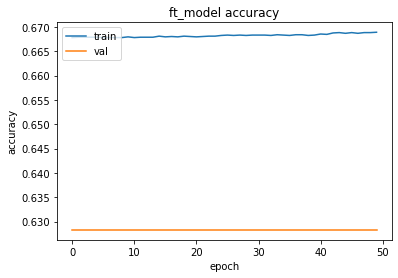

In [135]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('ft_model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## w2v

In [137]:
w2v_weights = np.zeros((len(word2id2), 100))

for word, i in word2id2.items():

    if word == 'PAD':
        continue

    try:
        w2v_weights[i] = w2v.wv[word]
    
    except KeyError:
        continue
        w2v_weights[i] = w2v.wv['опрагпллирао']

inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id2), output_dim=100, 
                                       trainable=False,
                                       weights=[w2v_weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [138]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=150,
          epochs=50)

Epoch 1/50
92/92 [==============================] - 10s 97ms/step - loss: 0.6512 - accuracy: 0.6509 - val_loss: 0.6518 - val_accuracy: 0.6283
Epoch 2/50
92/92 [==============================] - 1s 10ms/step - loss: 0.6216 - accuracy: 0.6650 - val_loss: 0.6421 - val_accuracy: 0.6283
Epoch 3/50
92/92 [==============================] - 1s 10ms/step - loss: 0.6090 - accuracy: 0.6659 - val_loss: 0.6331 - val_accuracy: 0.6283
Epoch 4/50
92/92 [==============================] - 1s 9ms/step - loss: 0.5992 - accuracy: 0.6663 - val_loss: 0.6246 - val_accuracy: 0.6297
Epoch 5/50
92/92 [==============================] - 1s 10ms/step - loss: 0.5909 - accuracy: 0.6666 - val_loss: 0.6169 - val_accuracy: 0.6297
Epoch 6/50
92/92 [==============================] - 1s 9ms/step - loss: 0.5837 - accuracy: 0.6673 - val_loss: 0.6101 - val_accuracy: 0.6338
Epoch 7/50
92/92 [==============================] - 1s 9ms/step - loss: 0.5774 - accuracy: 0.6691 - val_loss: 0.6039 - val_accuracy: 0.6380
Epoch 8/50
92/9

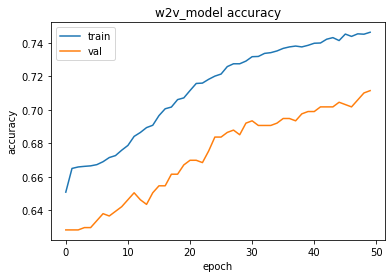

In [139]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('w2v_model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**из приведённых выше моделей, лучшие результаты показала w2v_model (хотя при изменении параметров, в значительной степени меняются результаты)**

## rus-vectores